In [ ]:
# %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

ERROR: Operation cancelled by user


Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c datathonindoml-2022
!unzip datathonindoml-2022.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/6309.tif    
  inflating: train/train/631.tif     
  inflating: train/train/6310.tif    
  inflating: train/train/6311.tif    
  inflating: train/train/6312.tif    
  inflating: train/train/6313.tif    
  inflating: train/train/6314.tif    
  inflating: train/train/6315.tif    
  inflating: train/train/6316.tif    
  inflating: train/train/6317.tif    
  inflating: train/train/6318.tif    
  inflating: train/train/6319.tif    
  inflating: train/train/632.tif     
  inflating: train/train/6320.tif    
  inflating: train/train/6321.tif    
  inflating: train/train/6322.tif    
  inflating: train/train/6323.tif    
  inflating: train/train/6324.tif    
  inflating: train/train/6325.tif    
  inflating: train/train/6326.tif    
  inflating: train/train/6327.tif    
  inflating: train/train/6328.tif    
  inflating: train/train/6329.tif    
  inflating: train/train/633.tif     
  inflating: train/train/6330.tif    

In [3]:
import joblib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import pandas as pd
import os
import numpy as np

In [4]:
# classes = {'0': 'letter', '1': 'form', '2': 'email', '3': 'handwritten', '4': 'advertisement', '5': 'scientific report', '6': 'scientific publication', '7': 'specification', '8': 'file folder', '9': 'news article', '10': 'budget', '11': 'invoice', '12': 'presentation', '13': 'questionnaire', '14': 'resume', '15': 'memo'}
root_path = '/content/'
def make_doc_dirs(path): 
    if not os.path.exists(path):
        os.mkdir(path)
    for label in range(16): 
        if not os.path.exists(path + string.ascii_lowercase[label]):
            os.mkdir(path + string.ascii_lowercase[label])
# if not os.path.exists('/kaggle/working/training/'):
#     os.mkdir('/kaggle/working/training/')
make_doc_dirs('/content/training/')
make_doc_dirs('/content/testing/')
make_doc_dirs('/content/validating/')

In [5]:
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
all_images_path=pd.read_csv("/content/train_labels.csv")
all_images_path.head()
X_train, X_test, y_train, y_test = train_test_split( all_images_path["id"], all_images_path["label"], test_size=0.10, random_state=40,shuffle=True,stratify=all_images_path["label"])
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=2/9, random_state=40,shuffle=True,stratify=y_train)

In [7]:
import shutil

# src_path = r"E:\demos\files\report\profit.txt"
# dst_path = r"/kaggle/working/training/\profit.txt"
for path, label in zip(X_train,y_train):
    shutil.copy(r"/content/train/train/"+str(path)+".tif", r"./training/"+string.ascii_lowercase[label]+"/"+str(path)+".tif")
for path, label in zip(X_test,y_test):
    shutil.copy(r"/content/train/train/"+str(path)+".tif", r"./testing/"+string.ascii_lowercase[label]+"/"+str(path)+".tif")
for path, label in zip(X_val,y_val):
    shutil.copy(r"/content/train/train/"+str(path)+".tif", r"./validating/"+string.ascii_lowercase[label]+"/"+str(path)+".tif")

In [8]:
import tensorflow as tf
from keras.backend import set_session

In [9]:
import seaborn as sns
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [10]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1000, 
                        inter_op_parallelism_threads=1000, 
                        allow_soft_placement=True)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# train=[]
# for dirname, _, filenames in os.walk('./training'):
#     for filename in filenames:
#         train.append(os.path.join(dirname, filename))
# test=[]
# for dirname, _, filenames in os.walk('./testing'):
#     for filename in filenames:
#         test.append(os.path.join(dirname, filename))
# cv=[]
# for dirname, _, filenames in os.walk('./validation'):
#     for filename in filenames:
#         cv.append(os.path.join(dirname, filename))
train=[]
for path,label in zip(X_train,y_train):
    train.append("./training/"+string.ascii_lowercase[label]+"/"+str(path)+".tif")
test=[]
for path,label in zip(X_test,y_test):
    test.append("./testing/"+string.ascii_lowercase[label]+"/"+str(path)+".tif")
cv=[]
for path,label in zip(X_val,y_val):
    cv.append("./validating/"+string.ascii_lowercase[label]+"/"+str(path)+".tif")

In [13]:
y_cv=y_val.copy()

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
train_datagen = ImageDataGenerator(rotation_range=45,brightness_range=[0.5,1.5],zoom_range=0.3,
rescale = 1./255)
test_datagen = ImageDataGenerator(
rescale = 1./255)
cv_datagen = ImageDataGenerator(
rescale = 1./255)

In [16]:
train_it = train_datagen.flow_from_directory('./training/',batch_size=32,target_size=(256, 256))
# load and iterate validation dataset
test_it = test_datagen.flow_from_directory('./testing/',batch_size=32,target_size=(256, 256))
# load and iterate test dataset
cv_it = cv_datagen.flow_from_directory('./validating/', batch_size=32,target_size=(256, 256))

Found 11200 images belonging to 16 classes.
Found 1600 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.


## **TRANSFER LEARNING WITH IMAGENET INITIALIZED VGG**

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
# import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 256,256
batch_size = 32
epochs = 50


model =keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
# mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
mcp_save = ModelCheckpoint('model_vgg.hdf5', monitor="val_accuracy", mode="max",save_best_only=True, verbose=1)

In [ ]:
from keras.layers import GlobalAveragePooling2D

In [ ]:
for layer in model.layers:
    layer.trainable=True

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(learning_rate=0.0001), metrics=["accuracy"])


In [ ]:
history = model_final.fit(
train_it,
steps_per_epoch =11200/32,
epochs=10,    
validation_data=cv_it,
validation_steps=3200/32,
callbacks=[reduce_lr,mcp_save])

Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.7829
Epoch 1: val_accuracy improved from 0.73969 to 0.74031, saving model to model_vgg.hdf5
350/350 [==============================] - 284s 810ms/step - loss: 0.7012 - accuracy: 0.7829 - val_loss: 0.9258 - val_accuracy: 0.7403 - lr: 1.0000e-06
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.7746
Epoch 2: val_accuracy improved from 0.74031 to 0.74187, saving model to model_vgg.hdf5
350/350 [==============================] - 284s 810ms/step - loss: 0.7071 - accuracy: 0.7746 - val_loss: 0.9206 - val_accuracy: 0.7419 - lr: 1.0000e-06
Epoch 3/10
350/350 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.7761
Epoch 3: val_accuracy did not improve from 0.74187
350/350 [==============================] - 283s 809ms/step - loss: 0.7141 - accuracy: 0.7761 - val_loss: 0.9220 - val_accuracy: 0.7412 - lr: 1.0000e-06
Epoch 4/10
350/350 [===========

KeyboardInterrupt: ignored

In [28]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

def plot_loss(history):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

    # list of epoch numbers
    x = list(range(1,len(history.history['val_loss'])+1))


    vy = history.history['val_loss']
    ty = history.history['loss']
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
def plot_acc(history):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('model accuracy')

    # list of epoch numbers
    x = list(range(1,len(history.history['val_loss'])+1))

    vy = history.history['val_accuracy']
    ty = history.history['accuracy']
    ax.plot(x, vy, 'b', label="Validation accuracy")
    ax.plot(x, ty, 'r', label="Train accuracy")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
model_final.load_weights('model_vgg.hdf5')

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print("The accuracy for model-Pretrained vgg-16 initiazlied with image net:",score[1]*100,"%")

The accuracy for model-Pretrained vgg-16 initiazlied with image net: 75.49999952316284 %


In [ ]:
test_it_tb = test_datagen.flow_from_directory("/content/validation",batch_size=1,target_size=(256,256),shuffle=False)

footer_test= model_final.predict_generator(test_it_tb,steps = 900)
out=model_final.predict(test_it_tb)
output=np.argmax(out,axis=1)
name=[int(x[11:16]) for x in test_it_tb.filenames]
df=pd.DataFrame(columns=["id","label"])
df.id=name
df.label=output
df.to_csv("./submission_vgg.csv",index=False)

Found 900 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


# Xception

In [ ]:
def step_decay(epoch):
	initial_lrate = 0.001
	max_iter=40
	lrate = initial_lrate *(1-epoch/max_iter)**0.5
	return lrate

In [ ]:
pretrained_model= keras.applications.Xception(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = LearningRateScheduler(step_decay)
# mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
mcp_save = ModelCheckpoint('model_xception.hdf5', monitor="val_accuracy", mode="max",save_best_only=True, verbose=1)

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable=True

#Adding custom Layers 
x = pretrained_model.output
x = Flatten()(x)
x = Dense(224, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(112, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = pretrained_model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =SGD(learning_rate=0.01,momentum=0.9), metrics=["accuracy"])

In [ ]:
history = model_final.fit(
train_it,
steps_per_epoch =11200/64,
epochs=40,    
validation_data=cv_it,
validation_steps=3200/64,
callbacks=[reduce_lr,mcp_save])

Epoch 1/40
175/175 [==============================] - ETA: 0s - loss: 2.7656 - accuracy: 0.0827
Epoch 1: val_accuracy improved from -inf to 0.12375, saving model to model_xception.hdf5
175/175 [==============================] - 172s 924ms/step - loss: 2.7656 - accuracy: 0.0827 - val_loss: 2.7391 - val_accuracy: 0.1238 - lr: 0.0010
Epoch 2/40
175/175 [==============================] - ETA: 0s - loss: 2.6801 - accuracy: 0.1452
Epoch 2: val_accuracy improved from 0.12375 to 0.23000, saving model to model_xception.hdf5
175/175 [==============================] - 159s 908ms/step - loss: 2.6801 - accuracy: 0.1452 - val_loss: 2.6023 - val_accuracy: 0.2300 - lr: 9.8742e-04
Epoch 3/40
175/175 [==============================] - ETA: 0s - loss: 2.4782 - accuracy: 0.2293
Epoch 3: val_accuracy improved from 0.23000 to 0.31375, saving model to model_xception.hdf5
175/175 [==============================] - 159s 908ms/step - loss: 2.4782 - accuracy: 0.2293 - val_loss: 2.3828 - val_accuracy: 0.3137 - lr

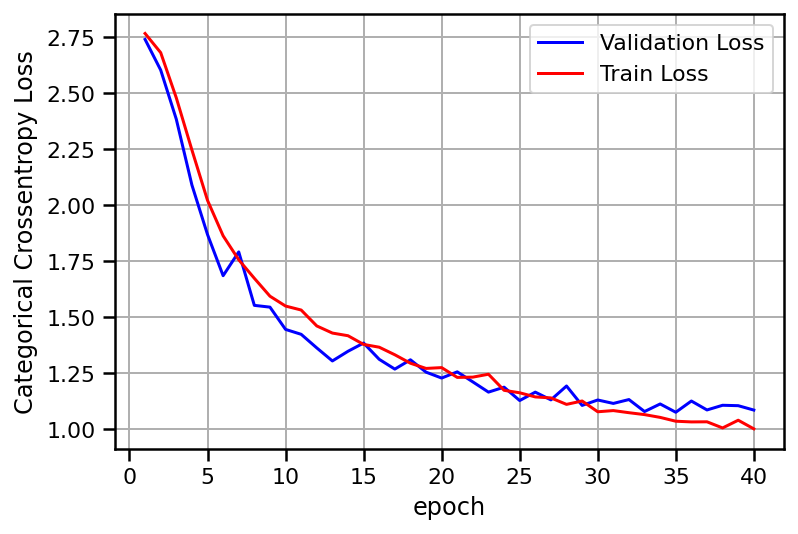

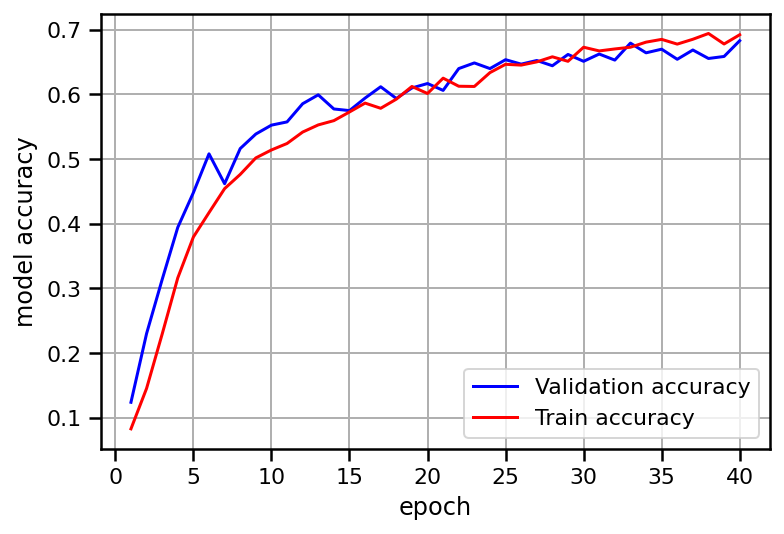

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[1.0513315200805664, 0.6800000071525574]

In [ ]:
model_final.load_weights('./model_xception.hdf5')

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[1.0513315200805664, 0.6800000071525574]

In [ ]:
test_it_tb = test_datagen.flow_from_directory("/content/validation",batch_size=1,target_size=(256,256),shuffle=False)

footer_test= model_final.predict_generator(test_it_tb,steps = 900)
out=model_final.predict(test_it_tb)
output=np.argmax(out,axis=1)
name=[int(x[11:16]) for x in test_it_tb.filenames]
df=pd.DataFrame(columns=["id","label"])
df.id=name
df.label=output
df.to_csv("./submission_xception.csv",index=False)

Found 900 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


# Inception

In [ ]:
def step_decay(epoch):
	initial_lrate = 0.001
	max_iter=40
	lrate = initial_lrate *(1-epoch/max_iter)**0.5
	return lrate

In [ ]:
pretrained_model= keras.applications.Xception(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = LearningRateScheduler(step_decay)
# mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
mcp_save = ModelCheckpoint('model_inception.hdf5', monitor="val_accuracy", mode="max",save_best_only=True, verbose=1)

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable=True

#Adding custom Layers 
x = pretrained_model.output
x = Flatten()(x)
x = Dense(224, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(112, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = pretrained_model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =SGD(learning_rate=0.01,momentum=0.9), metrics=["accuracy"])

In [ ]:
history = model_final.fit(
train_it,
steps_per_epoch =11200/32,
epochs=40,    
validation_data=cv_it,
validation_steps=3200/32,
callbacks=[reduce_lr,mcp_save])

Epoch 1/40
350/350 [==============================] - ETA: 0s - loss: 2.7149 - accuracy: 0.1158
Epoch 1: val_accuracy improved from -inf to 0.20812, saving model to model_inception.hdf5
350/350 [==============================] - 321s 868ms/step - loss: 2.7149 - accuracy: 0.1158 - val_loss: 2.6075 - val_accuracy: 0.2081 - lr: 0.0010
Epoch 2/40
350/350 [==============================] - ETA: 0s - loss: 2.3409 - accuracy: 0.2779
Epoch 2: val_accuracy improved from 0.20812 to 0.36469, saving model to model_inception.hdf5
350/350 [==============================] - 305s 870ms/step - loss: 2.3409 - accuracy: 0.2779 - val_loss: 2.1269 - val_accuracy: 0.3647 - lr: 9.8742e-04
Epoch 3/40
350/350 [==============================] - ETA: 0s - loss: 1.9213 - accuracy: 0.3972
Epoch 3: val_accuracy improved from 0.36469 to 0.45969, saving model to model_inception.hdf5
350/350 [==============================] - 301s 860ms/step - loss: 1.9213 - accuracy: 0.3972 - val_loss: 1.7094 - val_accuracy: 0.4597 -

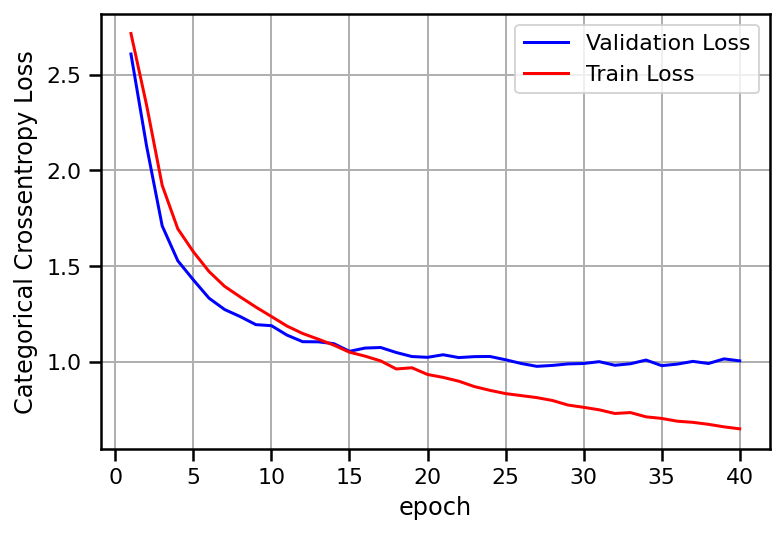

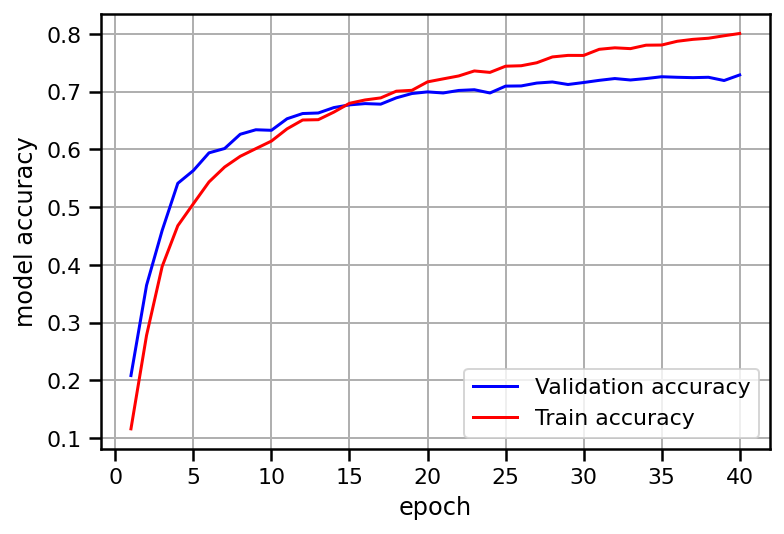

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[0.9581742882728577, 0.7431250214576721]

In [ ]:
model_final.load_weights('./model_inception.hdf5')

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[0.9581742286682129, 0.7431250214576721]

In [ ]:
test_it_tb = test_datagen.flow_from_directory("/content/validation",batch_size=1,target_size=(256,256),shuffle=False)

footer_test= model_final.predict_generator(test_it_tb,steps = 900)
out=model_final.predict(test_it_tb)
output=np.argmax(out,axis=1)
name=[int(x[11:16]) for x in test_it_tb.filenames]
df=pd.DataFrame(columns=["id","label"])
df.id=name
df.label=output
df.to_csv("./submission_inception.csv",index=False)

Found 900 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


# resnet50

In [19]:
def step_decay(epoch):
	initial_lrate = 0.001
	max_iter=40
	lrate = initial_lrate *(1-epoch/max_iter)**0.5
	return lrate

In [20]:
pretrained_model= keras.applications.Xception(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights="imagenet")

83697664/83683744 [==============================] - 1s 0us/step


In [21]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = LearningRateScheduler(step_decay)
# mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model_resnet50.hdf5', monitor="val_accuracy", mode="max",save_best_only=True, verbose=1)

In [22]:
from tensorflow.keras.optimizers import SGD

In [23]:
for layer in pretrained_model.layers:
    layer.trainable=True

#Adding custom Layers 
x = pretrained_model.output
x = Flatten()(x)
x = Dense(224, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(112, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = pretrained_model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =SGD(learning_rate=0.01,momentum=0.9), metrics=["accuracy"])

In [24]:
# model_final.load_weights('/content/model_resnet50.hdf5')

In [25]:
# print(tf.__version__)

In [ ]:
history = model_final.fit(
train_it,
steps_per_epoch =11200/32,
epochs=40,    
validation_data=cv_it,
validation_steps=3200/32,
callbacks=[reduce_lr,mcp_save])

Epoch 1/40
350/350 [==============================] - ETA: 0s - loss: 2.7148 - accuracy: 0.1151
Epoch 1: val_accuracy improved from -inf to 0.22969, saving model to /content/drive/MyDrive/Colab Notebooks/model_resnet50.hdf5
350/350 [==============================] - 316s 854ms/step - loss: 2.7148 - accuracy: 0.1151 - val_loss: 2.6159 - val_accuracy: 0.2297 - lr: 0.0010
Epoch 2/40
350/350 [==============================] - ETA: 0s - loss: 2.3173 - accuracy: 0.2906
Epoch 2: val_accuracy improved from 0.22969 to 0.42250, saving model to /content/drive/MyDrive/Colab Notebooks/model_resnet50.hdf5
350/350 [==============================] - 305s 870ms/step - loss: 2.3173 - accuracy: 0.2906 - val_loss: 2.0119 - val_accuracy: 0.4225 - lr: 9.8742e-04
Epoch 3/40
350/350 [==============================] - ETA: 0s - loss: 1.8711 - accuracy: 0.4199
Epoch 3: val_accuracy improved from 0.42250 to 0.50000, saving model to /content/drive/MyDrive/Colab Notebooks/model_resnet50.hdf5
350/350 [=============

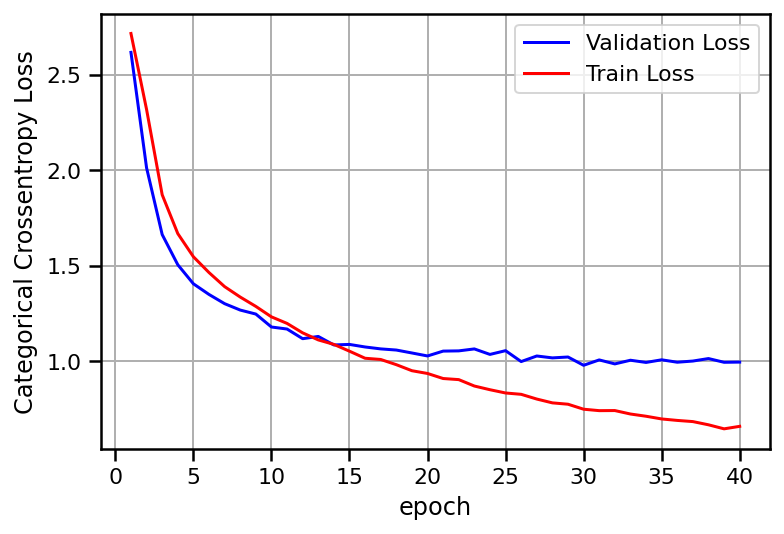

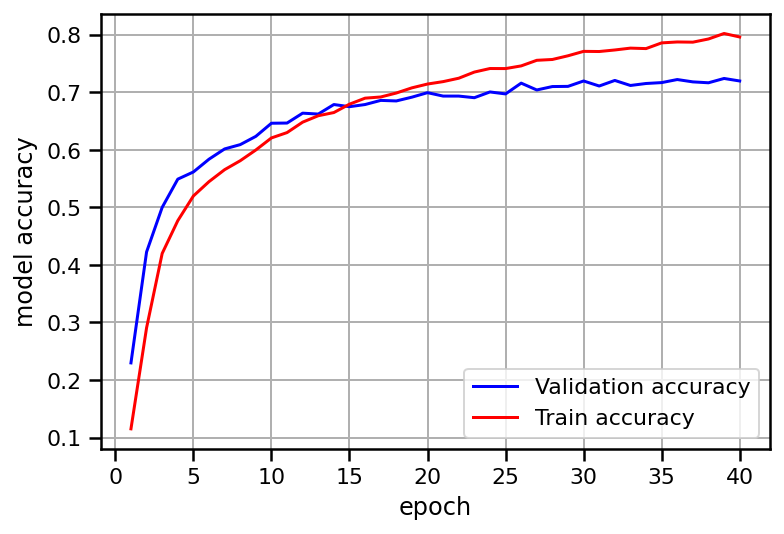

In [29]:
plot_loss(history)
plot_acc(history)

In [30]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [31]:
score

[0.9495071172714233, 0.7431250214576721]

In [32]:
model_final.load_weights('/content/drive/MyDrive/Colab Notebooks/model_resnet50.hdf5')

In [33]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [34]:
score

[0.9557586908340454, 0.7406250238418579]

In [36]:
test_it_tb = test_datagen.flow_from_directory("/content/validation",batch_size=1,target_size=(256,256),shuffle=False)

footer_test= model_final.predict_generator(test_it_tb,steps = 900)
out=model_final.predict(test_it_tb)
output=np.argmax(out,axis=1)
name=[int(x[11:16]) for x in test_it_tb.filenames]
df=pd.DataFrame(columns=["id","label"])
df.id=name
df.label=output
df.to_csv("./submission_resnet50.csv",index=False)

Found 900 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


# InceptionResNetV2

In [37]:
def step_decay(epoch):
	initial_lrate = 0.001
	max_iter=40
	lrate = initial_lrate *(1-epoch/max_iter)**0.5
	return lrate

In [38]:
pretrained_model= keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights="imagenet")

219070464/219055592 [==============================] - 4s 0us/step


In [39]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = LearningRateScheduler(step_decay)
# mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model_InceptionResNetV2.hdf5', monitor="val_accuracy", mode="max",save_best_only=True, verbose=1)

In [40]:
from tensorflow.keras.optimizers import SGD

In [41]:
for layer in pretrained_model.layers:
    layer.trainable=True

#Adding custom Layers 
x = pretrained_model.output
x = Flatten()(x)
x = Dense(224, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(112, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = pretrained_model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =SGD(learning_rate=0.01,momentum=0.9), metrics=["accuracy"])

In [42]:
# model_final.load_weights('/content/model_resnet50.hdf5')

In [ ]:
# print(tf.__version__)

In [ ]:
history = model_final.fit(
train_it,
steps_per_epoch =11200/32,
epochs=40,    
validation_data=cv_it,
validation_steps=3200/32,
callbacks=[reduce_lr,mcp_save])

Epoch 1/40
350/350 [==============================] - ETA: 0s - loss: 2.5751 - accuracy: 0.1779
Epoch 1: val_accuracy improved from -inf to 0.38000, saving model to /content/drive/MyDrive/Colab Notebooks/model_InceptionResNetV2.hdf5
350/350 [==============================] - 336s 902ms/step - loss: 2.5751 - accuracy: 0.1779 - val_loss: 2.0872 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 2/40
350/350 [==============================] - ETA: 0s - loss: 1.9011 - accuracy: 0.4028
Epoch 2: val_accuracy improved from 0.38000 to 0.51844, saving model to /content/drive/MyDrive/Colab Notebooks/model_InceptionResNetV2.hdf5
350/350 [==============================] - 319s 910ms/step - loss: 1.9011 - accuracy: 0.4028 - val_loss: 1.5694 - val_accuracy: 0.5184 - lr: 9.8742e-04
Epoch 3/40
350/350 [==============================] - ETA: 0s - loss: 1.6309 - accuracy: 0.4953
Epoch 3: val_accuracy improved from 0.51844 to 0.56000, saving model to /content/drive/MyDrive/Colab Notebooks/model_InceptionResNetV2.

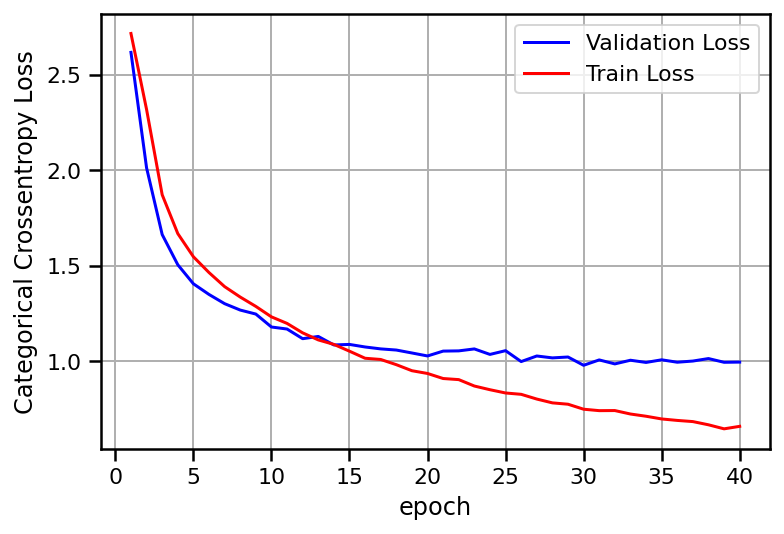

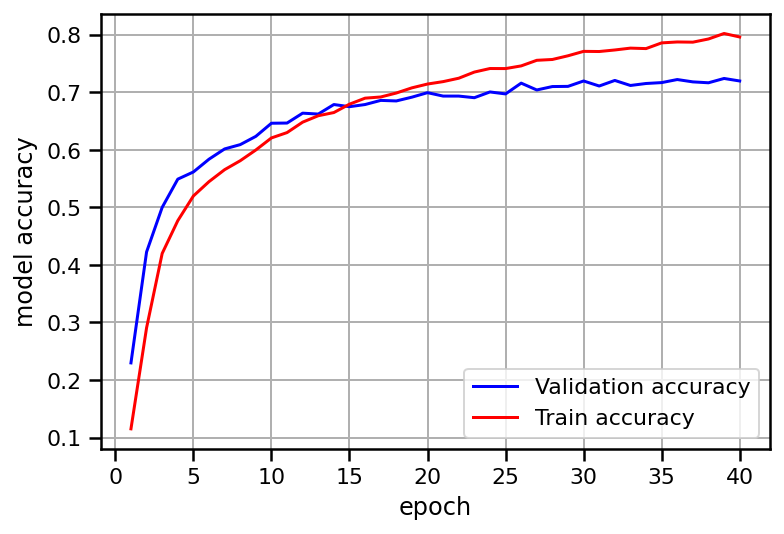

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[0.9495071172714233, 0.7431250214576721]

In [ ]:
model_final.load_weights('/content/drive/MyDrive/Colab Notebooks/model_InceptionResNetV2.hdf5')

In [ ]:
score=model_final.evaluate_generator(test_it,steps=1600/32,workers=-1, use_multiprocessing=True, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[0.9557586908340454, 0.7406250238418579]

In [ ]:
test_it_tb = test_datagen.flow_from_directory("/content/validation",batch_size=1,target_size=(256,256),shuffle=False)

footer_test= model_final.predict_generator(test_it_tb,steps = 900)
out=model_final.predict(test_it_tb)
output=np.argmax(out,axis=1)
name=[int(x[11:16]) for x in test_it_tb.filenames]
df=pd.DataFrame(columns=["id","label"])
df.id=name
df.label=output
df.to_csv("./submission_InceptionResNetV2.csv",index=False)

Found 900 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
